In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import cv2
import os
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import bin2cell as b2c
import celltypist
from celltypist import models
#create directory for stardist input/output files
path = ".../square_002um/"
os.chdir(path)
print(b2c.__version__)

0.3.3


# Comparing destriped vs. non-destriped bin2cell outputs

This notebook provides a side-by-side comparison of two `bin2cell` (`b2c`) AnnData objects:

- **`adata_with_d`**: Destriped `b2c` output with count adjustment. This dataset was processed using `b2c.destripe(adata, adjust_counts=True)`.
- **`adata_wo_d`**: Non-destriped `b2c` output without count adjustment. This dataset was processed using `b2c.destripe(adata, adjust_counts=False)`, creating destriped input for GEX segmentation but with the expression data itself being unchanged.

All other steps were identical between runs. As such, the two objects have identical input to the GEX and H&E image segmentations, resulting in identical output. Thusly, the objects have the same object IDs for matching cells, allowing us to easily compare outcomes in both destriped and non-destriped. CellTypist is employed in a fashion similar to the manuscript's comparison of bin2cell output and 8um spaceranger bins.

In [2]:
adata_wo_d = sc.read_h5ad('m_brain_b2c_non_destripped_plus_salvage.h5ad')
adata_with_d = sc.read_h5ad('m_brain_b2c_destripped_plus_salvage.h5ad')

In [3]:
sc.pp.calculate_qc_metrics(adata_wo_d, inplace=True)
sc.pp.calculate_qc_metrics(adata_with_d, inplace=True)

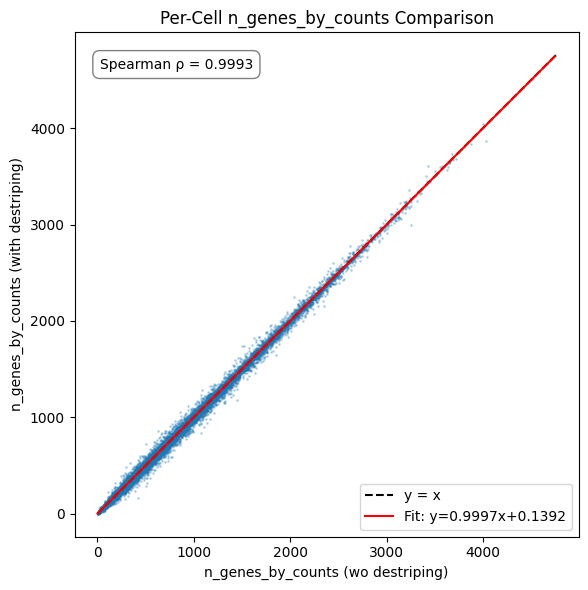

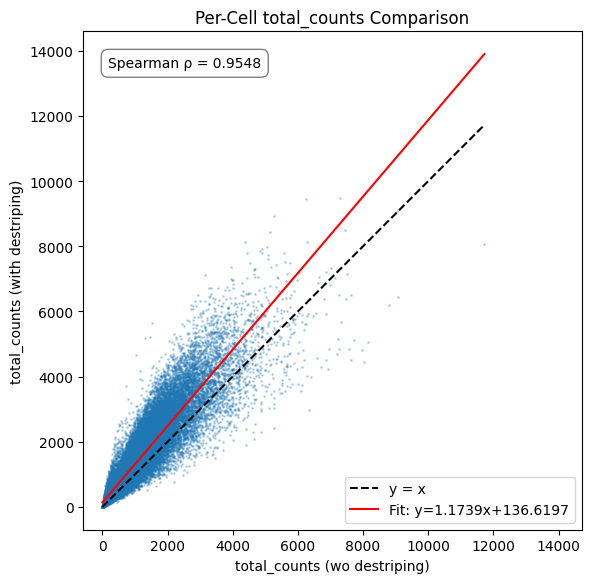

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Align both AnnData objects on the common set of cells
common_cells = adata_wo_d.obs_names.intersection(adata_with_d.obs_names)
adata_wo_d_aligned = adata_wo_d[common_cells]
adata_with_d_aligned = adata_with_d[common_cells]

def compare_metric(x, y, xlabel, ylabel, title):
    # Calculate correlation and regression
    spearman_rho, _ = spearmanr(x, y)
    slope, intercept = np.polyfit(x, y, 1)
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = slope * x_fit + intercept
    max_val = max(x.max(), y.max())

    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(x, y, s=1, alpha=0.25)
    plt.plot([0, max_val], [0, max_val], 'k--', label='y = x')
    plt.plot(x_fit, y_fit, 'r-', label=f'Fit: y={slope:.4f}x+{intercept:.4f}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.text(0.05, 0.95, f'Spearman ρ = {spearman_rho:.4f}',
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray'))
    plt.legend()
    plt.axis('square')
    plt.tight_layout()
    plt.show()

# 1. n_genes_by_counts
compare_metric(
    x=adata_wo_d_aligned.obs['n_genes_by_counts'].values,
    y=adata_with_d_aligned.obs['n_genes_by_counts'].values,
    xlabel='n_genes_by_counts (wo destriping)',
    ylabel='n_genes_by_counts (with destriping)',
    title='Per-Cell n_genes_by_counts Comparison'
)

# 2. total_counts
compare_metric(
    x=adata_wo_d_aligned.obs['total_counts'].values,
    y=adata_with_d_aligned.obs['total_counts'].values,
    xlabel='total_counts (wo destriping)',
    ylabel='total_counts (with destriping)',
    title='Per-Cell total_counts Comparison'
)


The impact of destriping on gene count is minimal, as the destriping procedure cannot create counts for genes not already present in a bin and any differences stem from the occasional differing call in label expansion. The count total sees a minor increase, matching what can be seen in the destriping impact inspection plots of the original tutorial notebook.

In [5]:
# predict celltypist 
sc.pp.normalize_total(adata_wo_d_aligned,target_sum=1e4)
sc.pp.log1p(adata_wo_d_aligned)
predictions_wo_d = celltypist.annotate(adata_wo_d_aligned, model = 'Mouse_Whole_Brain.pkl', majority_voting = False)
adata_wo_d_aligned = predictions_wo_d.to_adata()
adata_wo_d_aligned

🔬 Input data has 69902 cells and 18823 genes
🔗 Matching reference genes in the model
🧬 4603 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


AnnData object with n_obs × n_vars = 69902 × 18823
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'predicted_labels', 'conf_score'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial', 'log1p'
    obsm: 'spatial', 'spatial_cropped_150_buffer'

In [6]:
# predict celltypist 
sc.pp.normalize_total(adata_with_d_aligned,target_sum=1e4)
sc.pp.log1p(adata_with_d_aligned)
predictions_with_d = celltypist.annotate(adata_with_d_aligned, model = 'Mouse_Whole_Brain.pkl', majority_voting = False)
adata_with_d_aligned = predictions_with_d.to_adata()
adata_with_d_aligned

🔬 Input data has 69902 cells and 18823 genes
🔗 Matching reference genes in the model
🧬 4603 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


AnnData object with n_obs × n_vars = 69902 × 18823
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'predicted_labels', 'conf_score'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial', 'log1p'
    obsm: 'spatial', 'spatial_cropped_150_buffer'

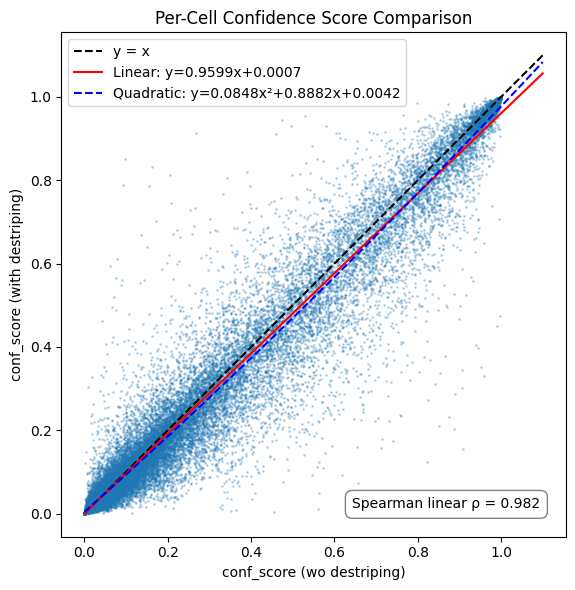

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Extract confidence scores 
x = adata_wo_d_aligned.obs['conf_score'].values
y = adata_with_d_aligned.obs['conf_score'].values

# Compute Spearman correlation
spearman_rho, _ = spearmanr(x, y)

# Fit linear regression (1st degree)
slope, intercept = np.polyfit(x, y, 1)
x_fit = np.linspace(0, 1.1, 200)
y_fit_linear = slope * x_fit + intercept

# Fit 2nd-degree polynomial (quadratic)
coeffs_quad = np.polyfit(x, y, 2)
y_fit_quad = np.polyval(coeffs_quad, x_fit)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(x, y, s=1, alpha=0.25)
plt.plot([0, 1.1], [0, 1.1], 'k--', label='y = x')
plt.plot(x_fit, y_fit_linear, 'r-', label=f'Linear: y={slope:.4f}x+{intercept:.4f}')
plt.plot(x_fit, y_fit_quad, 'b--', label=f'Quadratic: y={coeffs_quad[0]:.4f}x²+{coeffs_quad[1]:.4f}x+{coeffs_quad[2]:.4f}')
plt.xlim(0, 1.1)
plt.ylim(0, 1.1)
plt.xlabel('conf_score (wo destriping)')
plt.ylabel('conf_score (with destriping)')
plt.title('Per-Cell Confidence Score Comparison')
plt.axis('square')

# Annotate correlation
plt.text(0.95, 0.05, f'Spearman linear ρ = {spearman_rho:.3f}', transform=plt.gca().transAxes,
         horizontalalignment='right', verticalalignment='bottom',
         bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray'))
plt.legend()
plt.tight_layout()
plt.show()


Inspecting CellTypist confidence scores at a single cell level reveals a high degree of agreement, with a very minor increase in the non-destriped representation of the data. However, outcomes vary on a per-cell level.

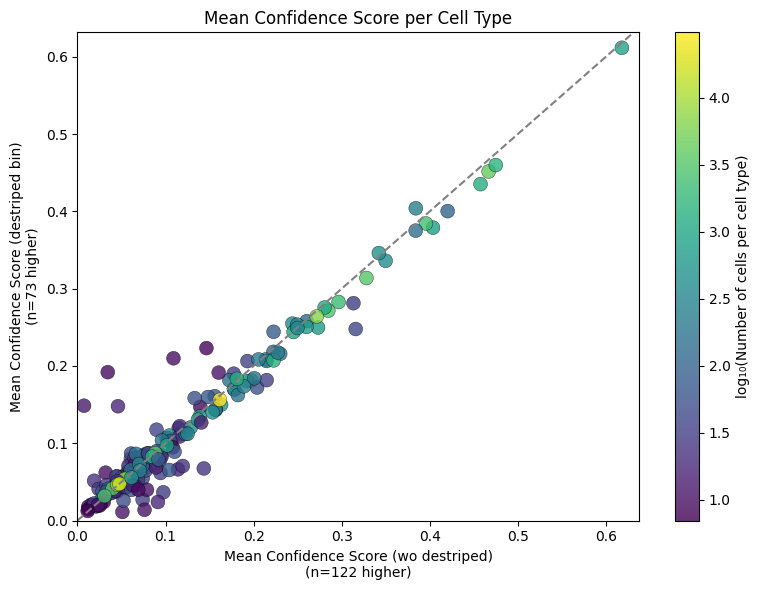

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute mean confidence and counts per cell type from aligned data
stats_wo_d = adata_wo_d_aligned.obs.groupby('predicted_labels')['conf_score'] \
    .agg(mean_conf='mean', count='count')
stats_with_d = adata_with_d_aligned.obs.groupby('predicted_labels')['conf_score'] \
    .agg(mean_conf='mean', count='count')

# Merge stats
stats = pd.merge(
    stats_wo_d,
    stats_with_d,
    left_index=True,
    right_index=True,
    suffixes=('_wo_destriped', '_destriped')
)

# Filter by minimum count
stats = stats[(stats['count_wo_destriped'] >= 5) | (stats['count_destriped'] >= 5)]

# Determine which version had higher mean confidence
stats['higher'] = stats.apply(
    lambda r: 'wo_destriped' if r['mean_conf_wo_destriped'] >= r['mean_conf_destriped']
    else 'destriped_bin',
    axis=1
)

# Total cell count per group (for size/log color)
stats['total_count'] = stats['count_wo_destriped'] + stats['count_destriped']
stats['log_count'] = np.log10(stats['total_count'])

# Count how many cell types favored each
counts = stats['higher'].value_counts()

# Plot (color = log10(cell count), no hue for processing)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    stats['mean_conf_wo_destriped'],
    stats['mean_conf_destriped'],
    c=stats['log_count'],
    cmap='viridis',
    s=100,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3
)
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel(f'Mean Confidence Score (wo destriped)\n(n={counts.get("wo_destriped", 0)} higher)')
plt.ylabel(f'Mean Confidence Score (destriped bin)\n(n={counts.get("destriped_bin", 0)} higher)')
plt.title('Mean Confidence Score per Cell Type')
plt.xlim(0, stats['mean_conf_wo_destriped'].max() + 0.02)
plt.ylim(0, stats['mean_conf_destriped'].max() + 0.02)

# Colorbar for log10(cell count)
cb = plt.colorbar(scatter)
cb.set_label('log₁₀(Number of cells per cell type)')

plt.tight_layout()
plt.show()


Inspecting this at a cell type level reveals similar findings, as one would expect. Colouring the individual cell type dots by the number of cells in the population reveals a particularly high degree of agreement in more abundant populations.

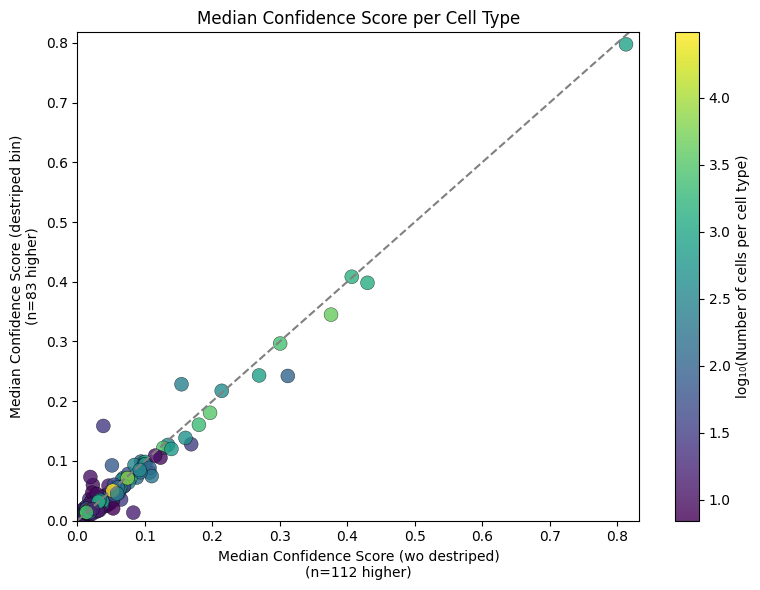

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute median confidence and counts per cell type from aligned data
stats_wo_d = adata_wo_d_aligned.obs.groupby('predicted_labels')['conf_score'] \
    .agg(median_conf='median', count='count')
stats_with_d = adata_with_d_aligned.obs.groupby('predicted_labels')['conf_score'] \
    .agg(median_conf='median', count='count')

# Merge stats
stats = pd.merge(
    stats_wo_d,
    stats_with_d,
    left_index=True,
    right_index=True,
    suffixes=('_wo_destriped', '_destriped')
)

# Filter by minimum count
stats = stats[(stats['count_wo_destriped'] >= 5) | (stats['count_destriped'] >= 5)]

# Determine which version had higher median confidence
stats['higher'] = stats.apply(
    lambda r: 'wo_destriped' if r['median_conf_wo_destriped'] >= r['median_conf_destriped']
    else 'destriped_bin',
    axis=1
)

# Compute total and log cell count per group
stats['total_count'] = stats['count_wo_destriped'] + stats['count_destriped']
stats['log_count'] = np.log10(stats['total_count'])

# Count how many cell types favored each
counts = stats['higher'].value_counts()

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    stats['median_conf_wo_destriped'],
    stats['median_conf_destriped'],
    c=stats['log_count'],
    cmap='viridis',
    s=100,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3
)
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel(f'Median Confidence Score (wo destriped)\n(n={counts.get("wo_destriped", 0)} higher)')
plt.ylabel(f'Median Confidence Score (destriped bin)\n(n={counts.get("destriped_bin", 0)} higher)')
plt.title('Median Confidence Score per Cell Type')
plt.xlim(0, stats['median_conf_wo_destriped'].max() + 0.02)
plt.ylim(0, stats['median_conf_destriped'].max() + 0.02)

# Colorbar
cb = plt.colorbar(scatter)
cb.set_label('log₁₀(Number of cells per cell type)')

plt.tight_layout()
plt.show()


An additional visualisation using the median instead of the mean.